# Previously we have considered how to work with Time Series data by ARIMA and ML techniques
# Here and now we are going to find connections and create approach to predict Q2 values depending on pumps, sprinkles and HE fouling effects

In [1]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import (
    TimeSeriesSplit, cross_validate, 
    KFold, train_test_split,
    ShuffleSplit
)
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import tree

from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from joblib import dump, load

In [3]:
# fc 119,120,121
fcs = [
    ("2021-03-09", "2021-04-12"), ("2021-04-12", "2021-05-11"), ("2021-05-11", "2021-09-20")
]

### All IDs used
* 299 Т1к после ТО
* 309 Р2контура
* 315 T1k before HE
* 317 Т2к перед ТО
* 319 Т2к после ТО
* 321 T reactor
* 325 Т2к выхТО1
* 327 Твозвуха
* 381 Iвг1
* 395 Iвг2
* 396 Iвг3
* 460 Т2к выхТО2
* 461 Т2к выхТО3
* 462 Т2к выхТО4
* 463 Т2к выхТО5
* 480 Q1k
* 481 Q2контура
#### Second loop I pumps id
* 406 2-1
* 407 2-2
* 408 2-3
* 409 2-4

In [4]:
sys.path.insert(0, os.path.split(os.path.abspath(""))[0])
sys.path.insert(0, os.path.join(os.path.split(os.path.abspath(""))[0], "app"))
os.listdir()

['!important_input_files',
 '!_prep_data_140423_090623.ipynb',
 '.ipynb_checkpoints',
 '.~irtt_cooling_system_general_analysis.ipynb',
 '4 окт -8 декабря 2022 Кублинский.csv',
 'alpha_coeffs.ipynb',
 'Analysis_HEs_Temperatures.ipynb',
 'Analysis_Predictions_Fouling_HE_CH1.ipynb',
 'Analysis_Predictions_Fouling_HE_CH2.ipynb',
 'archive',
 'control_operation_system_params',
 'Detail_Analysis_Statistics_Fouling_HE_CH1  - Basic data understanding_HEs_FIle_Prep.ipynb',
 'Detail_Analysis_Statistics_Fouling_HE_CH1  - Basic data understanding_Nozzles_HEs_FIle_Prep.ipynb',
 'Detail_Analysis_Statistics_Fouling_HE_CH2 - Not Time Series + Time Series_GBR.ipynb',
 'Detail_Analysis_Statistics_Fouling_HE_CH2 - Only fouling and WFR_Classification_Preoblem-.ipynb',
 'Detail_Analysis_Statistics_Fouling_HE_CH2 - Only fouling and WFR_Regression_Preoblem.ipynb',
 'Detail_Analysis_Statistics_Fouling_HE_CH2 - Time_Series_Analysis_ARIMA.ipynb',
 'Detail_Analysis_Statistics_Fouling_HE_CH2 - Time_Series_Analysi

In [5]:
from preprocessing import CsvRefactorer
from analytics import WaterFlowRates
from statistics import Statistics as st
from data_engineering import PeriodicDataPreprocess, FeatureEngineering
from statistics import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima import model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf, ccf

In [7]:
# df = pd.read_excel("rdy_for_fe_121020_to_210423.xlsx", index_col="Timestamp")
# df_nosma = pd.read_excel("rdy_for_fe_121020_to_210423_no_sma.xlsx", index_col="Timestamp")



In [8]:
# 5 min frequency

df_stats = pd.read_excel("!important_input_files/rdy_for_stats_121020_090623_1h_freq.xlsx", index_col="Timestamp")

In [9]:
df_stats["HE4_TOP"]

Timestamp
2020-10-13 00:00:00       8.514286
2020-10-13 13:00:00      17.028571
2020-10-13 14:00:00      25.542857
2020-10-13 15:00:00      34.057143
2020-10-13 16:00:00      42.571429
                          ...     
2023-06-09 06:00:00    5469.791667
2023-06-09 07:00:00    5471.593750
2023-06-09 08:00:00    5473.395833
2023-06-09 09:00:00    5475.197917
2023-06-09 10:00:00    5477.000000
Name: HE4_TOP, Length: 5880, dtype: float64

<AxesSubplot: xlabel='QbyIP', ylabel='Count'>

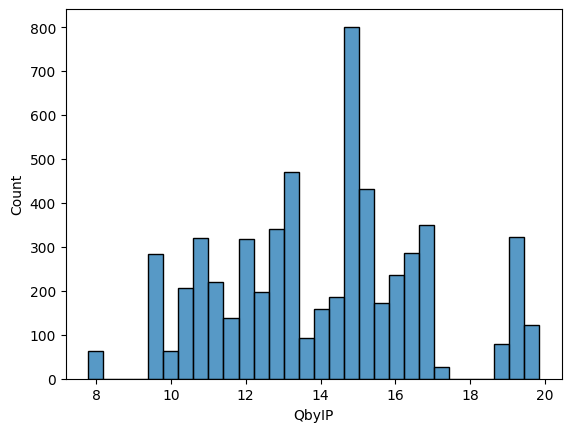

In [29]:
sns.histplot(df_stats["QbyIP"])

<AxesSubplot: xlabel='Q2', ylabel='Count'>

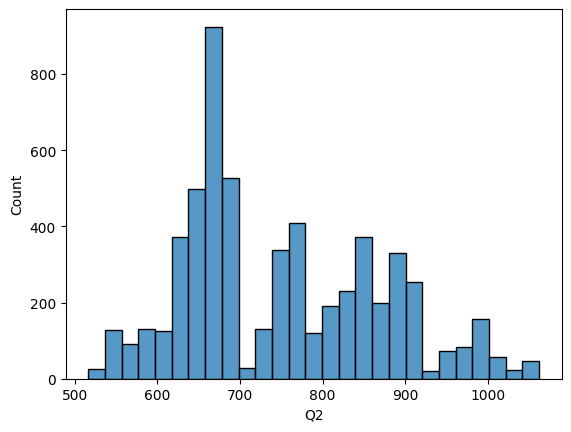

In [30]:
sns.histplot(df_stats["Q2"])

In [31]:
from statsmodels.api import qqplot

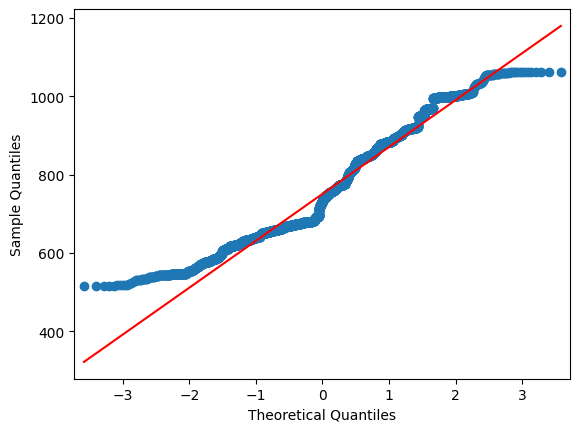

In [32]:
qqplot(df_stats["Q2"].to_numpy(), line ='s')
plt.show()

In [33]:
df_stats_gr = df_stats.groupby(pd.Grouper(freq="2h")).mean()

Timestamp
2020-10-13 00:00:00    651.812917
2020-10-13 12:00:00    652.146667
2020-10-13 14:00:00    652.204792
2020-10-13 16:00:00    651.961875
2020-10-13 18:00:00    652.137917
                          ...    
2023-06-09 02:00:00    808.175417
2023-06-09 04:00:00    806.845208
2023-06-09 06:00:00    805.513958
2023-06-09 08:00:00    804.389167
2023-06-09 10:00:00    803.285000
Name: Q2, Length: 929, dtype: float64


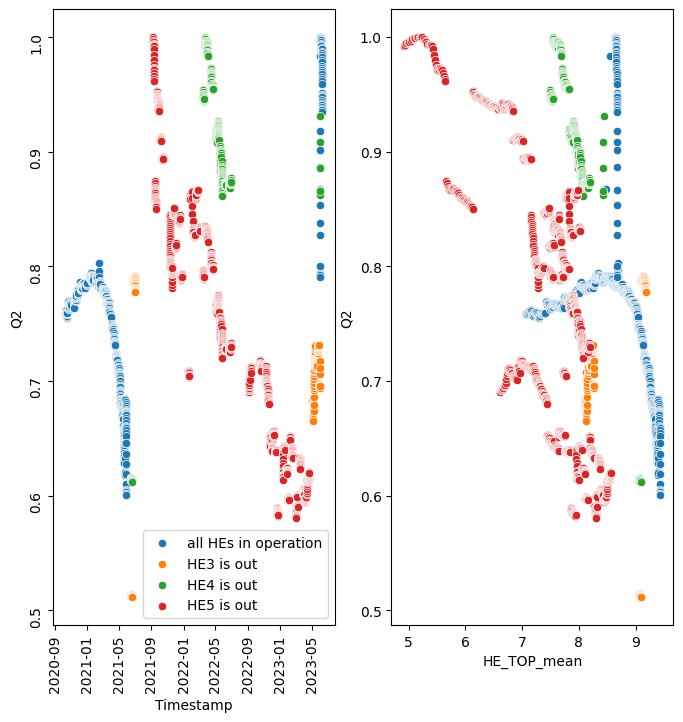

In [34]:

fig, axs = plt.subplots(1,2, figsize=(8,8))

qbyip = df_stats_gr["Q2"]

qbyip_all = qbyip[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
].dropna(axis=0)
qbyip3 = qbyip[df_stats_gr["HE3_status"] == 0].dropna(axis=0)
qbyip4 = qbyip[df_stats_gr["HE4_status"] == 0].dropna(axis=0)
qbyip5 = qbyip[df_stats_gr["HE5_status"] == 0].dropna(axis=0)

print(qbyip_all)

hetop_all = df_stats_gr[
    (df_stats_gr["HE3_status"] != 0)
    & (df_stats_gr["HE4_status"] != 0)
    & (df_stats_gr["HE5_status"] != 0)
    
]["HE_TOP_mean"].dropna(axis=0)
hetop3 = df_stats_gr[df_stats_gr["HE3_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop4 = df_stats_gr[df_stats_gr["HE4_status"] == 0]["HE_TOP_mean"].dropna(axis=0)
hetop5 = df_stats_gr[df_stats_gr["HE5_status"] == 0]["HE_TOP_mean"].dropna(axis=0)


sns.scatterplot(qbyip_all / qbyip_all.max(), ax=axs[0], label="all HEs in operation")
sns.scatterplot(qbyip3 / qbyip3.max(), ax=axs[0], label="HE3 is out")
sns.scatterplot(qbyip4 / qbyip4.max(), ax=axs[0], label="HE4 is out")
sns.scatterplot(qbyip5 / qbyip5.max(), ax=axs[0], label="HE5 is out")
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].max(), ax=axs[0])

sns.scatterplot(x=np.log(hetop_all), y=qbyip_all / qbyip_all.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop3), y=qbyip3 / qbyip3.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop4), y=qbyip4 / qbyip4.max(), ax=axs[1])
sns.scatterplot(x=np.log(hetop5), y=qbyip5 / qbyip5.max(), ax=axs[1])

axs[0].tick_params(rotation=90)
# sns.scatterplot(qbyip / df_stats.loc[:, ["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1))

# On a first look, all curves have similar trends and no matter what HEs are in operation
# However, the cycles that starts from 0 (HE_TOP_mean) have 2 different trends
# It's quite obvious that each cycle is non-stationry around QbyIP

# I assume that data of winter of 2021 is not clear cuz Tair is hardly reach -5
# However usually it dropsbelow -20 -> absolutly anomaly data
## Data till april of 2021 has dropped

In [35]:
# df_stats = df_stats.loc["2021-04":, :]
df_stats.shape

(5880, 39)

In [36]:
df_stats["HEs_num"] = df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)
df_stats["Q2_HEs_num"] = df_stats["Q2"] / df_stats["HEs_num"]
df_stats["QbyIP_HEs_num"] = df_stats["QbyIP"] / df_stats[["HE1_status", "HE2_status", "HE3_status", "HE4_status", "HE5_status"]].sum(axis=1)


In [37]:
df_stats.columns

Index(['P2', 'Q2', 'T1aHE', 'T1bHE', 'T2aHE', 'T2aHE1', 'T2aHE2', 'T2aHE3',
       'T2aHE4', 'T2aHE5', 'T2bHE', 'Tair', 'Treactor', 'p21', 'p22', 'p23',
       'p24', 'dt1', 'dt2', 'pumps2', 'dt_circuits_coef',
       'dt_circuits_coef_delta', 'I2mean', 'QbyIP', 'HE1_TOP', 'HE2_TOP',
       'HE3_TOP', 'HE4_TOP', 'HE5_TOP', 'HE1_status', 'HE2_status',
       'HE3_status', 'HE4_status', 'HE5_status', 'HE_TOP_mean', 'HEs_num',
       'Q2_HEs_num', 'QbyIP_HEs_num', 'Nozzles_TOP'],
      dtype='object')

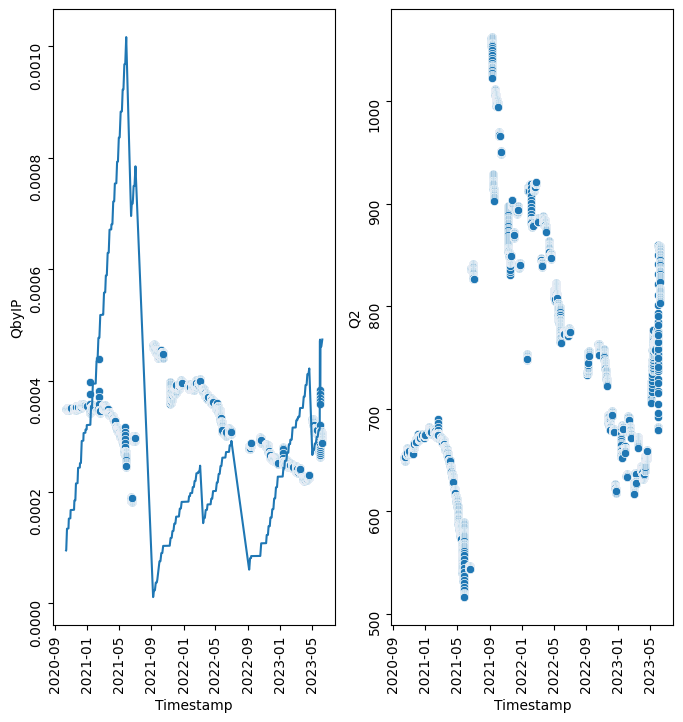

In [38]:
fig, axs = plt.subplots(1,2, figsize=(8,8))
sns.scatterplot(df_stats["QbyIP"]/df_stats_gr["QbyIP"].sum(), ax=axs[0])
sns.lineplot(df_stats["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.scatterplot(df_stats["Q2"], ax=axs[1])

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

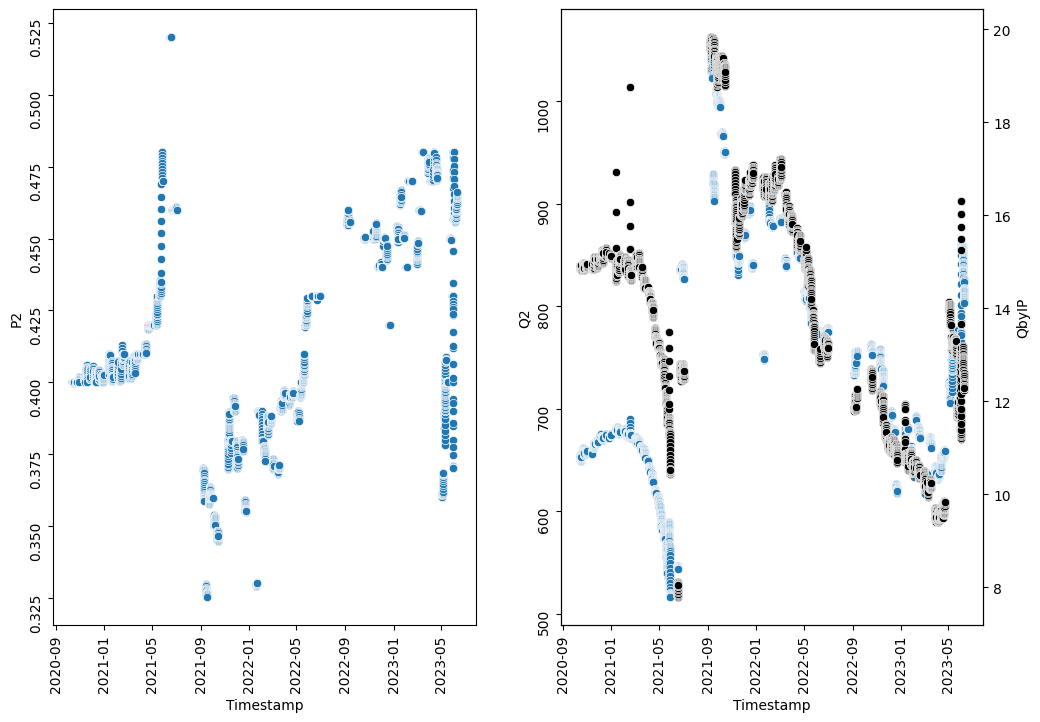

In [39]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
sns.scatterplot(df_stats["P2"], ax=axs[0])
# sns.lineplot(df_stats_gr["HE_TOP_mean"]/df_stats_gr["HE_TOP_mean"].sum(), ax=axs[0])
sns.scatterplot(df_stats["Q2"], ax=axs[1])
axs11 = axs[1].twinx()
sns.scatterplot(df_stats["QbyIP"], color="black", ax=axs11)
axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)

# From diary of maintenance of reactor systems i've learned that nozzles where cleaned only at summer of 2020, 2021. So they status must be taken into account

In [40]:
fe = FeatureEngineering(df_stats)

In [41]:
# nozzles_periods = [
#     ("2020-10-12", "2021-07-02"), 
#     ("2021-09-06", "2023-06-09"),
# #     ("2023-09-05", "2023-09-08")
# ]

nozzles_periods = [
    ("2021-09-06", "2023-06-09"),
#     ("2023-09-05", "2023-09-08")
]

df_stats = fe.make_time_onpower_feature(
    time_periods=nozzles_periods,
    feature_name="Nozzles_TOP",
    start=[0,0]
)

[3.86532663e+00 7.73065327e+00 1.15959799e+01 ... 1.53762693e+04
 1.53801347e+04 1.53840000e+04] 3980 3980


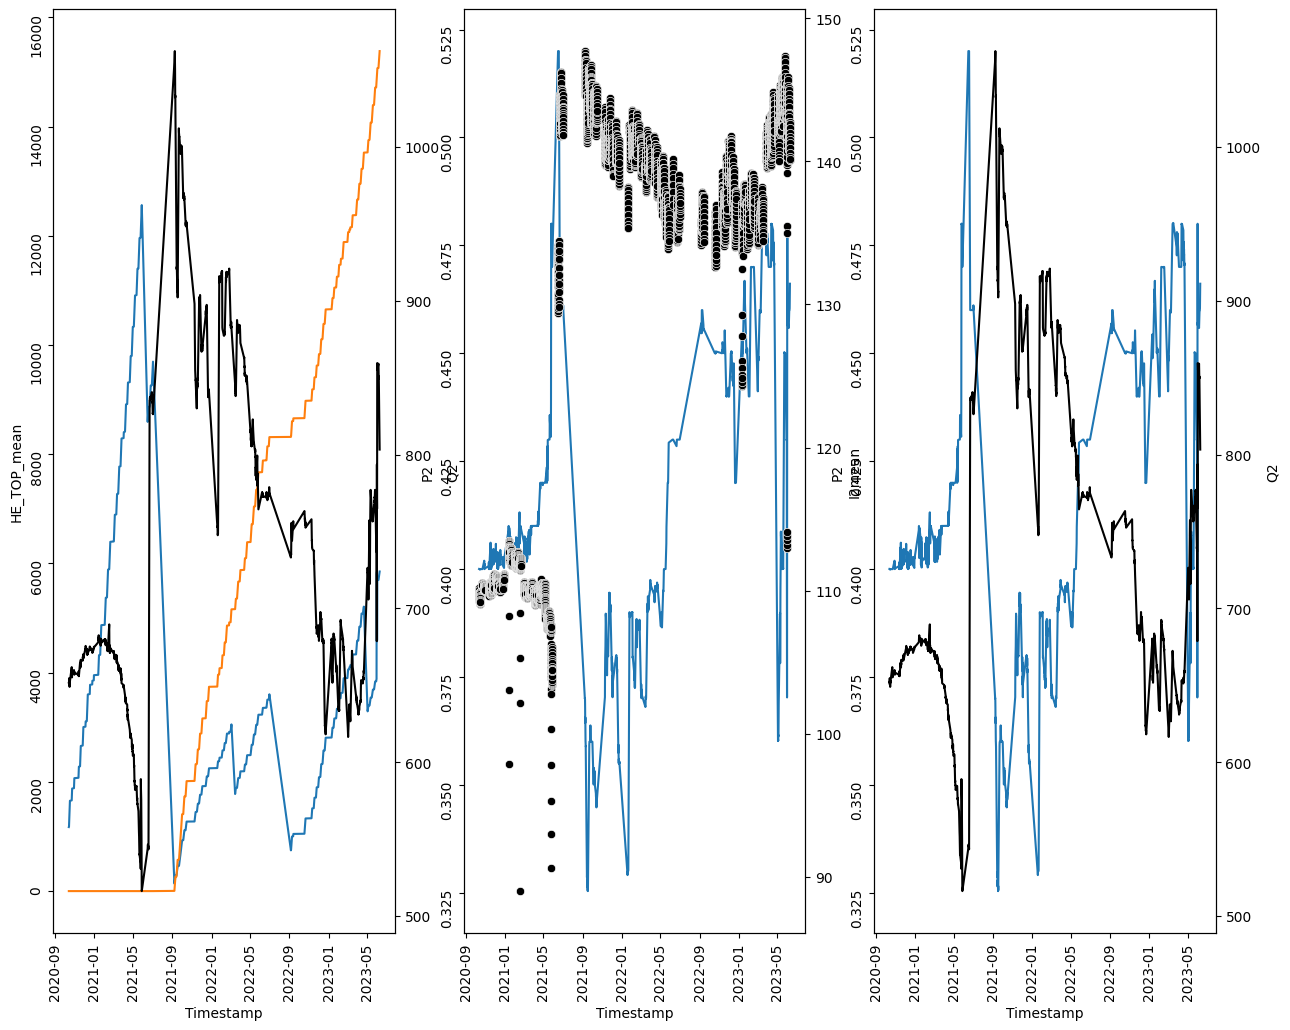

In [42]:
fig, axs = plt.subplots(1,3, figsize=(15,12))
ax0 = axs[0].twinx()
sns.lineplot(df_stats["Q2"], color="black", ax=ax0)
sns.lineplot(df_stats["HE_TOP_mean"], ax=axs[0])
sns.lineplot(df_stats["Nozzles_TOP"], ax=axs[0])

ax1 = axs[1].twinx()
sns.lineplot(df_stats["P2"], ax=axs[1])
sns.scatterplot(df_stats["I2mean"], color="black", ax=ax1)

ax2 = axs[2].twinx()
sns.lineplot(df_stats["P2"], ax=axs[2])
sns.lineplot(df_stats["Q2"], color="black", ax=ax2)

axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)
axs[2].tick_params(rotation=90)

In [43]:
df_stats["pumps2"].value_counts()

234     4243
123      653
134      579
124      322
1234      83
Name: pumps2, dtype: int64

<AxesSubplot: ylabel='QbyIP'>

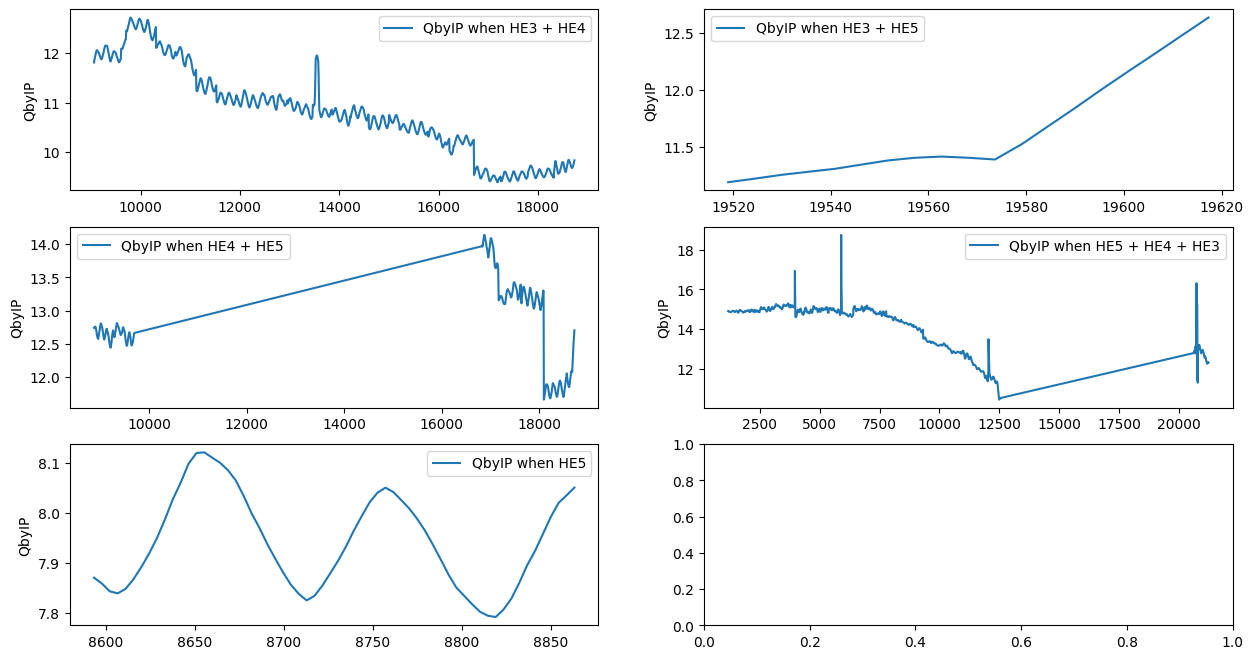

In [44]:
fig, axs = plt.subplots(3,2, figsize=(15,8))
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
#     y=df_stats["QbyIP"],
#     ax=axs[0][0],
#     label="Bare QbyIP"
# )
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=df_stats["Nozzles_TOP"]+df_stats["HE_TOP_mean"], 
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    ax=axs[2][0],
    label="QbyIP when HE5"
)


# As we can see from dependencies above:
## Strong dependencies from what HE operated 
# Need to consider  dependencies to operated pumps  additionally to aquired data

In [45]:
# fig, axs = plt.subplots(3,2, figsize=(15,8))

# # axs[0][0]
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] == 0)
#     ],
#     color="black",
#     ax=axs[0][0],
#     label="QbyIP when HE3 + HE4"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] == 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[0][0],
#     label="QbyIP when HE3 + HE4 + pumps234"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] == 0)
#         & (df_stats["pumps2"] == 124)
#     ],
#     ax=axs[0][0],
#     label="QbyIP when HE3 + HE4 + pumps124"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] == 0)
#         & (df_stats["pumps2"] == 123)
#     ],
#     ax=axs[0][0],
#     label="QbyIP when HE3 + HE4 + pumps123"
# )


# # axs[0][1]
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"], 
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE4_status"] == 0)
#     ],
#     color="black",
#     ax=axs[0][1],
#     label="QbyIP when HE3 + HE5"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE3_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE4_status"] == 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[0][1],
#     label="QbyIP when HE3 + HE5 + pumps234"
# )


# # axs[1][0]
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#     ],
#     color="black",
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5 + pumps234"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 134)
#     ],
#     color="red",
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5 + pumps134"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 123)
#     ],
#     color="red",
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5 + pumps123"
# )


# # axs[1][1]
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] != 0)
#     ],
#     color="black",
#     ax=axs[1][1],
#     label="QbyIP when HE5 + HE4 + HE3"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] != 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[1][1],
#     label="QbyIP when HE5 + HE4 + HE3 + pumps234"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] != 0)
#         & (df_stats["pumps2"] == 1234)
#     ],
#     ax=axs[1][1],
#     label="QbyIP when HE5 + HE4 + HE3 + pumps1234"
# )

 
# sns.scatterplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] == 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#     ],
#     color="black",
#     ax=axs[2][0],
#     label="QbyIP when HE5"
# )
# sns.lineplot(
#     x=df_stats["Nozzles_TOP"],
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] == 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 134)
#     ],
#     ax=axs[2][0],
#     label="QbyIP when HE5 + pumps134"
# )


<AxesSubplot: ylabel='QbyIP'>

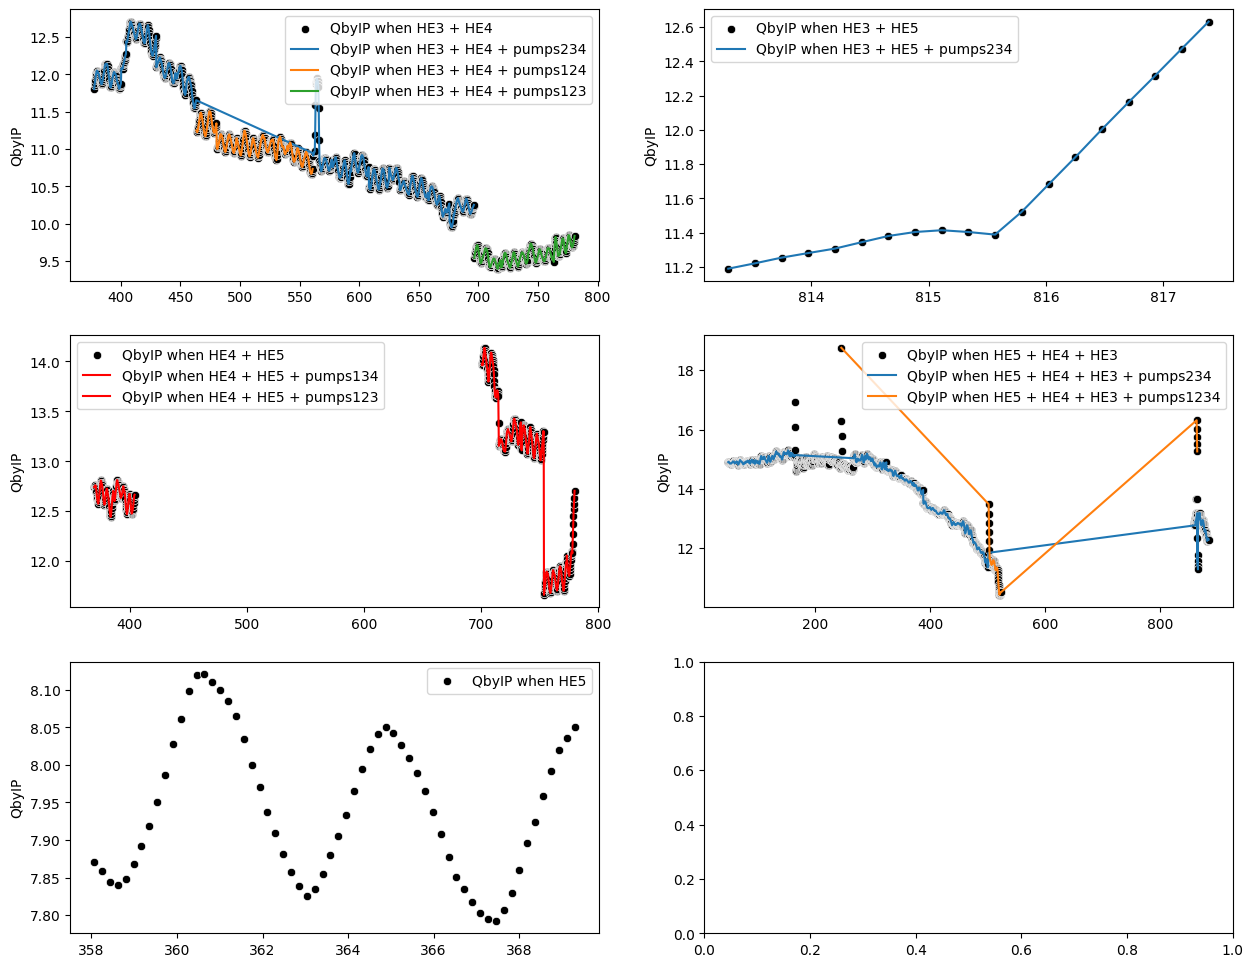

In [46]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

# axs[0][0]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="QbyIP when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="QbyIP when HE3 + HE5 + pumps234"
)


# axs[1][0]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5"
)
# sns.lineplot(
#     x=x,
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[1][0],
#     label="QbyIP when HE4 + HE5 + pumps234"
# )
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="QbyIP when HE4 + HE5 + pumps123"
)


# axs[1][1]
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="QbyIP when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="QbyIP when HE5"
)
# sns.lineplot(
#     x=x,
#     y=df_stats["QbyIP"][
#         (df_stats["HE4_status"] == 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 134)
#     ],
#     ax=axs[2][0],
#     label="QbyIP when HE5 + pumps134"
# )

<AxesSubplot: ylabel='Q2'>

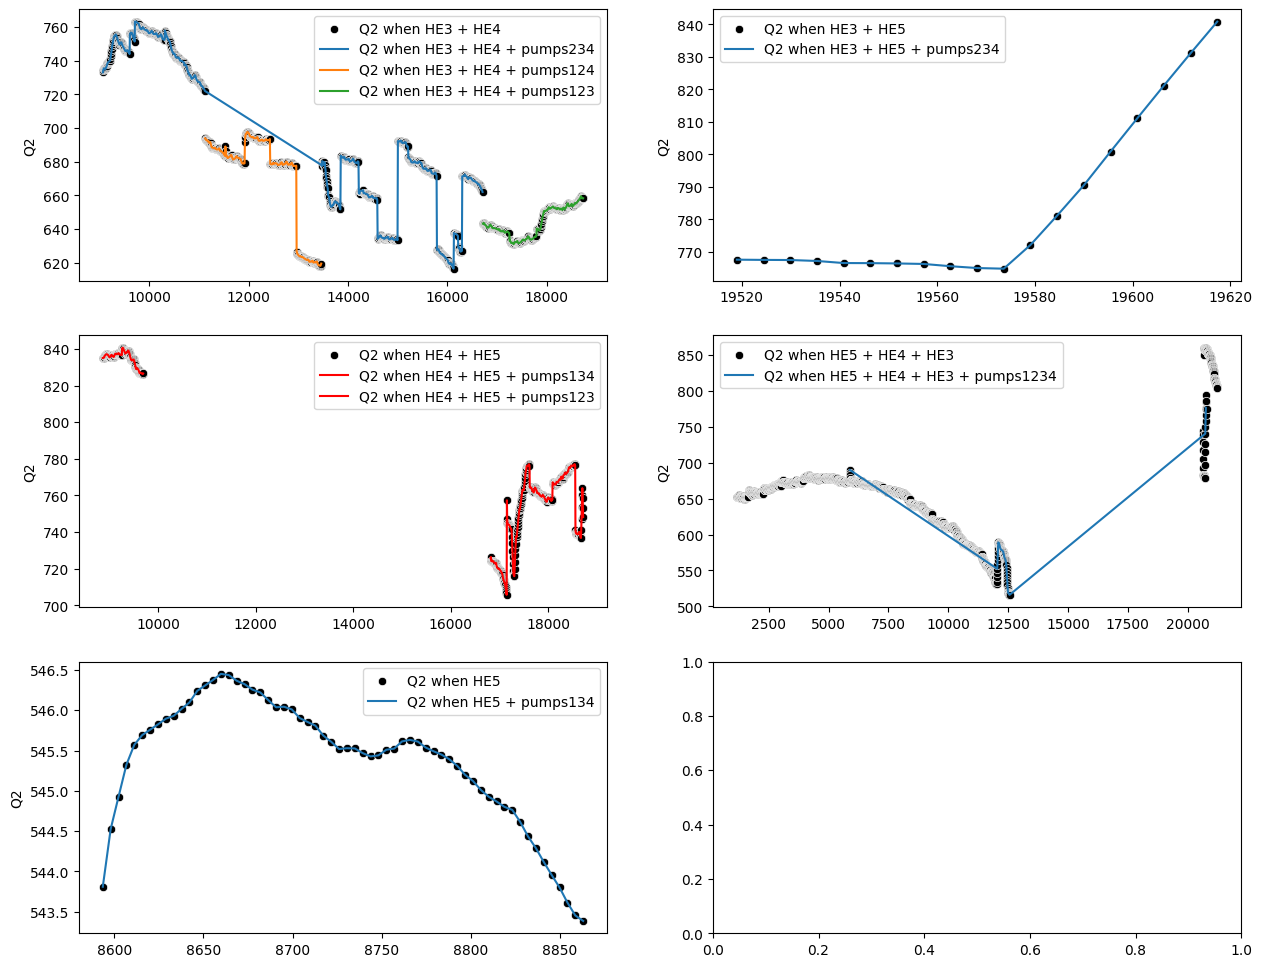

In [47]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

x = df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"]

# axs[0][0]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0][0],
    label="Q2 when HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps124"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0][0],
    label="Q2 when HE3 + HE4 + pumps123"
)


# axs[0][1]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
    ],
    color="black",
    ax=axs[0][1],
    label="Q2 when HE3 + HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE4_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0][1],
    label="Q2 when HE3 + HE5 + pumps234"
)

# axs[1][0]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5"
)
# sns.lineplot(
#     x=x,
#     y=df_stats["Q2"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] == 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[1][0],
#     label="Q2 when HE4 + HE5 + pumps234"
# )
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    color="red",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps134"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    color="red",
    ax=axs[1][0],
    label="Q2 when HE4 + HE5 + pumps123"
)



# axs[1][1]
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
    ],
    color="black",
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3"
)
# sns.lineplot(
#     x=x,
#     y=df_stats["Q2"][
#         (df_stats["HE4_status"] != 0)
#         & (df_stats["HE5_status"] != 0)
#         & (df_stats["HE3_status"] != 0)
#         & (df_stats["pumps2"] == 234)
#     ],
#     ax=axs[1][1],
#     label="Q2 when HE5 + HE4 + HE3 + pumps234"
# )
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] != 0)
        & (df_stats["pumps2"] == 1234)
    ],
    ax=axs[1][1],
    label="Q2 when HE5 + HE4 + HE3 + pumps1234"
)

 
sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
    ],
    color="black",
    ax=axs[2][0],
    label="Q2 when HE5"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE4_status"] == 0)
        & (df_stats["HE5_status"] != 0)
        & (df_stats["HE3_status"] == 0)
        & (df_stats["pumps2"] == 134)
    ],
    ax=axs[2][0],
    label="Q2 when HE5 + pumps134"
)

<AxesSubplot: xlabel='Nozzles_TOP', ylabel='Q2'>

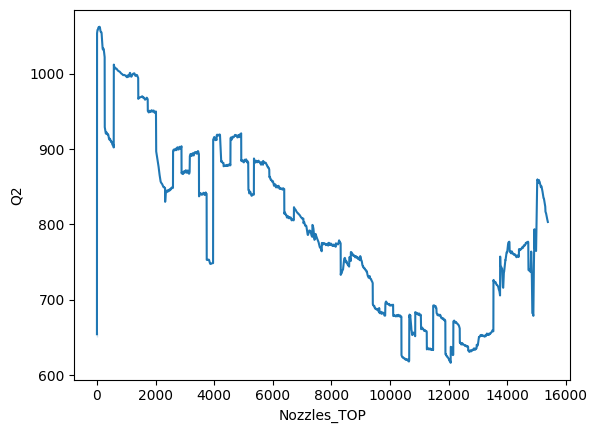

In [48]:
sns.lineplot(x=df_stats["Nozzles_TOP"], y=df_stats["Q2"])

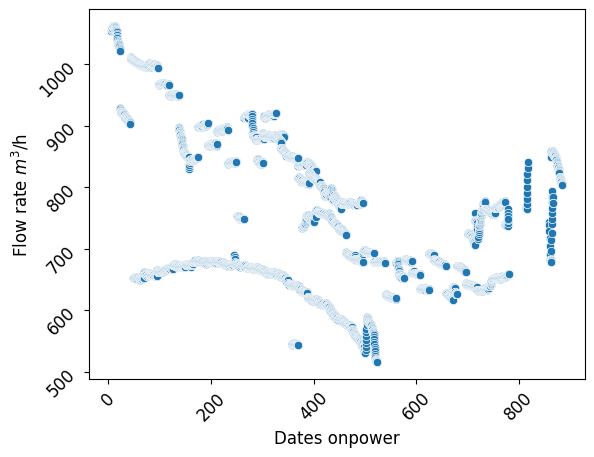

In [70]:
plt.rcParams.update({'font.size': 12})


x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24
sns.scatterplot(x=x, y=df_stats.loc[:,"Q2"])
# plt.ylabel("Объемный расход $м^3$/ч")
# plt.xlabel("Даты")
plt.ylabel("Flow rate $m^3$/h")
plt.xlabel("Dates onpower")
plt.tick_params(rotation=45)

In [61]:
df_stats

P2          Q2      T1aHE      T1bHE      T2aHE  \
Timestamp                                                                    
2020-10-13 00:00:00  0.400037  651.812917  41.489093  47.106167  33.441085   
2020-10-13 13:00:00  0.400000  652.146667  41.521119  47.103154  33.504863   
2020-10-13 14:00:00  0.400000  652.247083  41.665119  47.228287  33.671215   
2020-10-13 15:00:00  0.400000  652.162500  41.688156  47.239838  33.707642   
2020-10-13 16:00:00  0.400000  651.994167  41.639971  47.186255  33.663756   
...                       ...         ...        ...        ...        ...   
2023-06-09 06:00:00  0.465088  805.804583  46.490538  53.105898  33.247251   
2023-06-09 07:00:00  0.465514  805.223333  46.463895  53.079562  33.194609   
2023-06-09 08:00:00  0.465814  804.670000  46.395407  53.017473  33.084313   
2023-06-09 09:00:00  0.465964  804.108333  46.280309  52.909479  32.921800   
2023-06-09 10:00:00  0.466114  803.285000  44.792887  50.908553  32.209406   

                       T2aHE1    T2aHE2    T2aHE3    T2aHE4    T2aHE5  ...  \
Timestamp                                                              ...   
2020-10-13 00:00:00  0.329698  0.312868  0.342810  0.255702  0.265489  ...   
2020-10-13 13:00:00  0.330517  0.313245  0.344768  0.255599  0.265075  ...   
2020-10-13 14:00:00  0.330812  0.313467  0.345535  0.255696  0.265033  ...   
2020-10-13 15:00:00  0.331089  0.313671  0.346067  0.255722  0.264923  ...   
2020-10-13 16:00:00  0.331312  0.313815  0.346409  0.255710  0.264822  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-09 06:00:00  0.220955  0.231975  0.314525  0.236968  0.191494  ...   
2023-06-09 07:00:00  0.220786  0.231921  0.314377  0.236945  0.191499  ...   
2023-06-09 08:00:00  0.220630  0.231868  0.314166  0.236850  0.191511  ...   
2023-06-09 09:00:00  0.220419  0.231813  0.313900  0.236702  0.191517  ...   
2023-06-09 10:00:00  0.220874  0.233598  0.316634  0.238292  0.192213  ...   

                     HE1_status  HE2_status  HE3_status  HE4_status  \
Timestamp                                                             
2020-10-13 00:00:00           1           1           1           1   
2020-10-13 13:00:00           1           1           1           1   
2020-10-13 14:00:00           1           1           1           1   
2020-10-13 15:00:00           1           1           1           1   
2020-10-13 16:00:00           1           1           1           1   
...                         ...         ...         ...         ...   
2023-06-09 06:00:00           1           1           1           1   
2023-06-09 07:00:00           1           1           1           1   
2023-06-09 08:00:00           1           1           1           1   
2023-06-09 09:00:00           1           1           1           1   
2023-06-09 10:00:00           1           1           1           1   

                     HE5_status  HE_TOP_mean  HEs_num  Q2_HEs_num  \
Timestamp                                                           
2020-10-13 00:00:00           1  1172.784241        5  130.362583   
2020-10-13 13:00:00           1  1179.568481        5  130.429333   
2020-10-13 14:00:00           1  1186.352722        5  130.449417   
2020-10-13 15:00:00           1  1193.136962        5  130.432500   
2020-10-13 16:00:00           1  1199.921203        5  130.398833   
...                         ...          ...      ...         ...   
2023-06-09 06:00:00           1  5845.366404        5  161.160917   
2023-06-09 07:00:00           1  5847.324803        5  161.044667   
2023-06-09 08:00:00           1  5849.283202        5  160.934000   
2023-06-09 09:00:00           1  5851.241601        5  160.821667   
2023-06-09 10:00:00           1  5853.200000        5  160.657000   

                     QbyIP_HEs_num   Nozzles_TOP  
Timestamp                                         
2020-10-13 00:00:00       2.981042      0.000000  
2020-10-13 13:00:00   

Text(0.5, 0, 'Time onpower, eff.days')

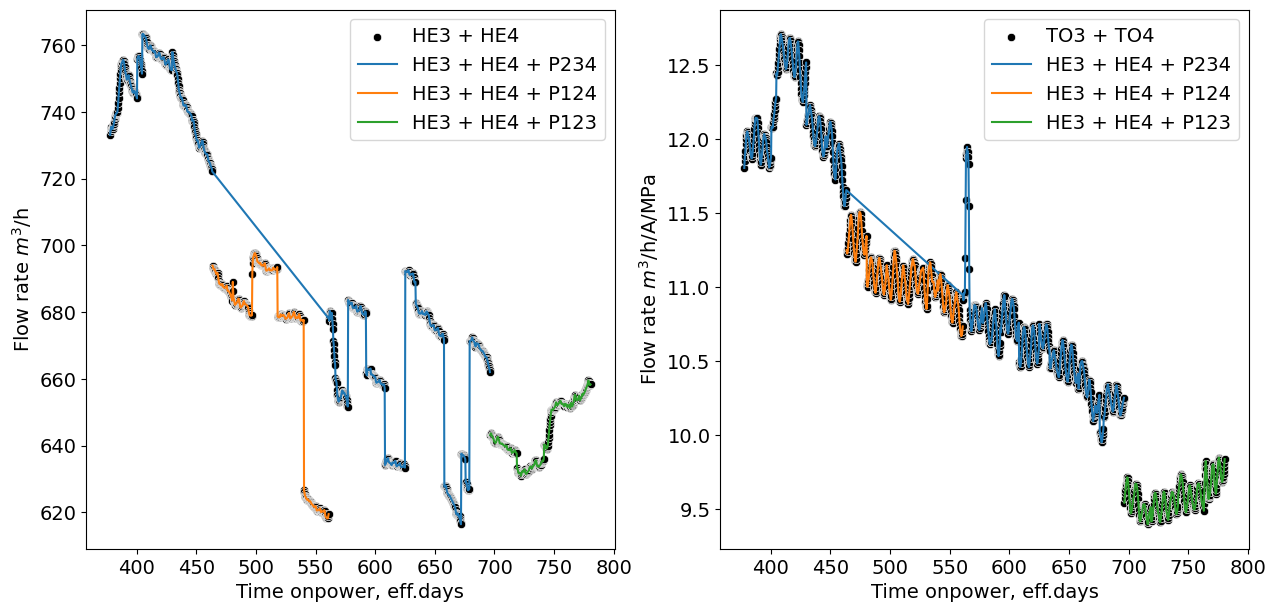

In [73]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2, figsize=(15,7))

x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

sns.scatterplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0],
#     label="ТО3 + ТО4"
    label="HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0],
#     label="ТО3 + ТО4 + Н234"
    label="HE3 + HE4 + P234"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0],
#     label="ТО3 + ТО4 + Н124"
    label="HE3 + HE4 + P124"
)
sns.lineplot(
    x=x,
    y=df_stats["Q2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0],
    label="HE3 + HE4 + P123"
)



sns.scatterplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[1],
    label="ТО3 + ТО4"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1],
#     label="ТО3 + ТО4 + Н234"
    label="HE3 + HE4 + P234"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[1],
#     label="ТО3 + ТО4 + Н124"
    label="HE3 + HE4 + P124"
)
sns.lineplot(
    x=x,
    y=df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[1],
#     label="ТО3 + ТО4 + Н123"
    label="HE3 + HE4 + P123"
)
axs[0].set_ylabel("Flow rate $m^3$/h")
axs[0].set_xlabel("Time onpower, eff.days")

# axs[0].set_ylabel("Объемный расход $м^3$/ч")
# axs[0].set_xlabel("Длительность работы, эфф.суток")

axs[1].set_ylabel("Flow rate $m^3$/h/A/MPa")
axs[1].set_xlabel("Time onpower, eff.days")

# axs[1].set_ylabel("Объемный расход $м^3$/ч/А/МПа")
# axs[1].set_xlabel("Длительность работы, эфф.суток")

Text(0.5, 0, 'Time onpower, eff.days')

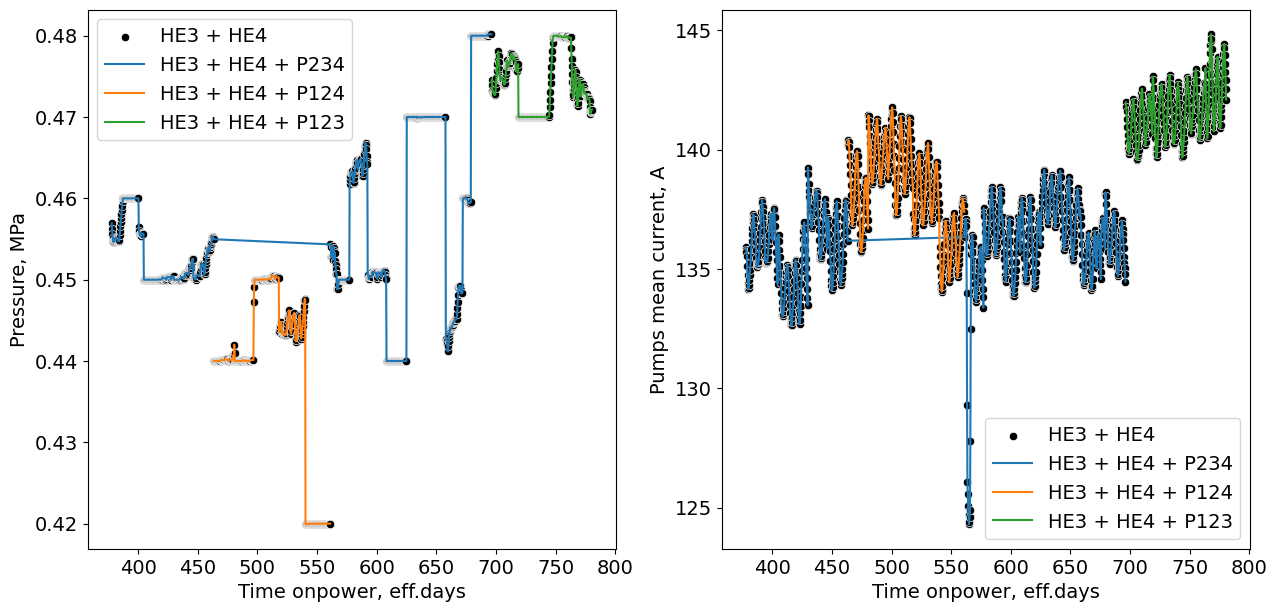

In [74]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2, figsize=(15,7))
x = (df_stats["HE_TOP_mean"] + df_stats["Nozzles_TOP"])/24

sns.scatterplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[0],
#     label="ТО3 + ТО4"
    label="HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[0],
#     label="ТО3 + ТО4 + Н234"
    label="HE3 + HE4 + P234"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[0],
#     label="ТО3 + ТО4 + Н124
    label="HE3 + HE4 + P124"
)
sns.lineplot(
    x=x,
    y=df_stats["P2"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[0],
#     label="ТО3 + ТО4 + Н123"
    label="HE3 + HE4 + P123"
)


sns.scatterplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
    ],
    color="black",
    ax=axs[1],
#     label="ТО3 + ТО4"
    label="HE3 + HE4"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ],
    ax=axs[1],
#     label="ТО3 + ТО4 + Н234"
    label="HE3 + HE4 + P234"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
    ],
    ax=axs[1],
#     label="ТО3 + ТО4 + Н124"
    label="HE3 + HE4 + P124"
)
sns.lineplot(
    x=x,
    y=df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 123)
    ],
    ax=axs[1],
#     label="ТО3 + ТО4 + Н123"
    label="HE3 + HE4 + P123"
)

axs[0].set_ylabel("Pressure, MPa")
axs[0].set_xlabel("Time onpower, eff.days")

# axs[0].set_ylabel("Давление, МПа")
# axs[0].set_xlabel("Длительность работы, эфф.суток")

axs[1].set_ylabel("Pumps mean current, А")
axs[1].set_xlabel("Time onpower, eff.days")

# plt.tick_params(rotation=90)

(0.20845482253004288, 0.4144764259588731)

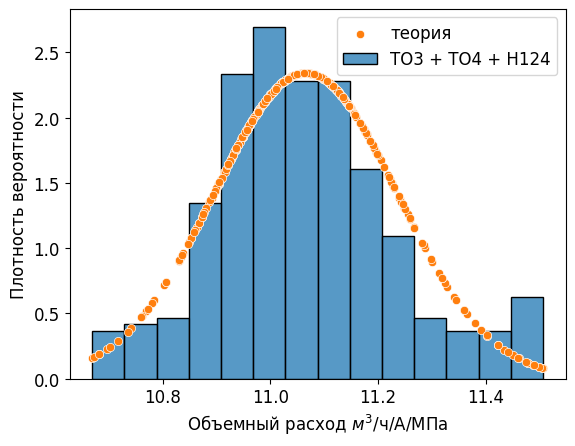

In [75]:
plt.rcParams.update({'font.size': 12})

data = df_stats["QbyIP"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["QbyIP"] < 11.7)
    ]

sns.histplot(
    data,
    stat="density",
    label="ТО3 + ТО4 + Н124"
)

mu, sigma = norm.fit(data)
nrm = norm(mu, sigma).pdf(data)
sns.scatterplot(x=data, y=nrm, label="теория")

plt.xlabel("Объемный расход $м^3$/ч/А/МПа")
plt.ylabel("Плотность вероятности")
scipy.stats.kurtosis(data), scipy.stats.skew(data)

(-0.6984974765661671, -0.2755206006038699)

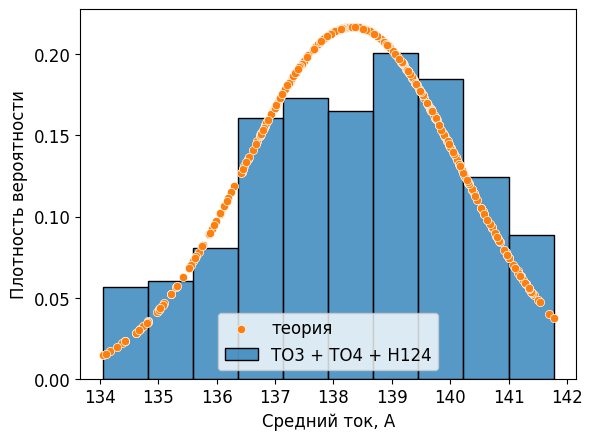

In [76]:
plt.rcParams.update({'font.size': 12})

data = df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["I2mean"] > 134)
        & (df_stats["I2mean"] < 145)
    ]

sns.histplot(
    data,
    stat="density",
    label="ТО3 + ТО4 + Н124"
)

mu, sigma = norm.fit(data)
nrm = norm(mu, sigma).pdf(data)
sns.scatterplot(x=data, y=nrm, label="теория")

plt.xlabel("Средний ток, А")
plt.ylabel("Плотность вероятности")
scipy.stats.kurtosis(data), scipy.stats.skew(data)

Text(0, 0.5, 'Probability')

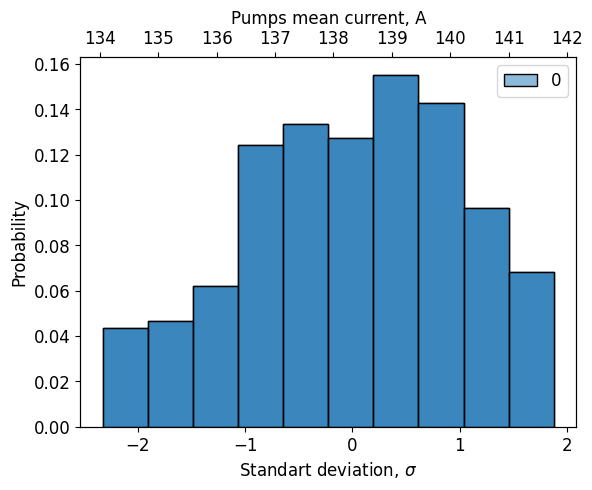

In [119]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()
ax2 = ax.twiny()
data = df_stats["I2mean"][
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 124)
        & (df_stats["I2mean"] > 134)
        & (df_stats["I2mean"] < 145)
    ]

data_ss = StandardScaler().fit_transform(data.to_numpy().reshape(-1,1))

sns.histplot(
    data_ss,
    stat="probability",
    ax=ax
)
sns.histplot(
    data,
    stat="probability",
    ax=ax2
)

ax2.set_xlabel("Pumps mean current, А")
ax.set_xlabel("Standart deviation, $\sigma$")
ax.set_ylabel("Probability")

# After pumps status were added as important feature to describe all dependencies we may consider distribution once again

(-4.752324038201918,
 6.703491901817652e-05,
 10,
 718,
 {'1%': -3.439490435810785,
  '5%': -2.8655738086413374,
  '10%': -2.568918067209286},
 870.3584493313808)

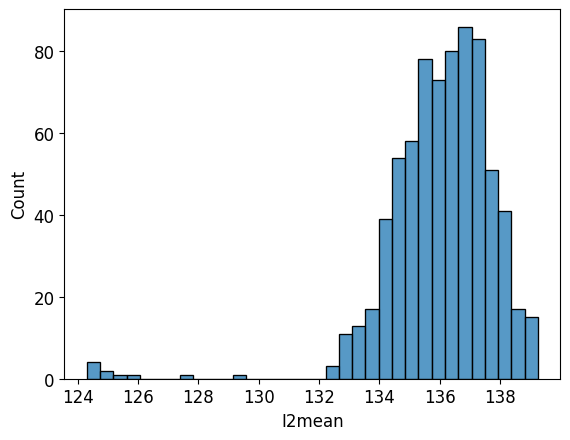

In [78]:
df_he34_p234 = (df_stats[
        (df_stats["HE3_status"] != 0)
        & (df_stats["HE4_status"] != 0)
        & (df_stats["HE5_status"] == 0)
        & (df_stats["pumps2"] == 234)
    ]
    ).dropna()
sns.histplot(
    df_he34_p234["I2mean"]
)

statsmodels.tsa.stattools.adfuller(
    df_he34_p234["I2mean"]
)

<AxesSubplot: >

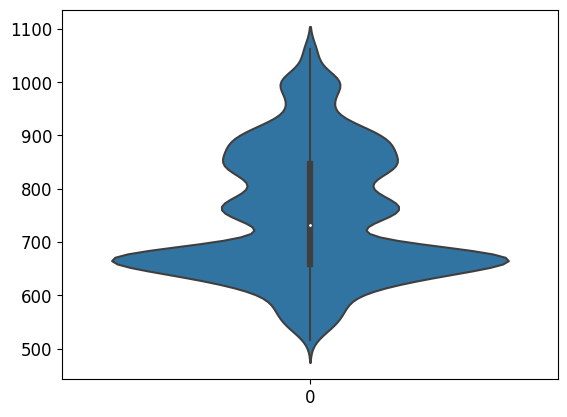

In [79]:
sns.violinplot(df_stats["Q2"])

In [80]:
df_stats["pumps2"].value_counts()

234     4243
123      653
134      579
124      322
1234      83
Name: pumps2, dtype: int64

In [91]:
selection_cols_Q2 = [
    "Q2", 
    "P2", 
    "I2mean", 
    "Nozzles_TOP", 
    "HE_TOP_mean",
    "HE3_status",
    "HE4_status", 
    "HE5_status",
    "pumps2", 
    "HEs_num"
    ]
df_stats_Q2 = df_stats.loc[
    :, 
    selection_cols_Q2
]

# df_stats_Q2 = df_stats_undersampled.loc[
#     :, 
#     [
#         "Q2", "P2", "I2mean", "Nozzles_TOP", 
#         "HE_TOP_mean","HE3_status",
#         "HE4_status", "HE5_status",
#         "pumps2",
#         "HEs_num"
#     ]
# ]

In [92]:
df_stats_Q2["pumps2"].value_counts()

234     4243
123      653
134      579
124      322
1234      83
Name: pumps2, dtype: int64

In [94]:
numerical_cols = [
    "Nozzles_TOP",
    "I2mean", 
    "HE_TOP_mean"
]
ct = ColumnTransformer(
        [
            ("numerical_data", StandardScaler(), numerical_cols),
            ("categorical_data", OneHotEncoder(sparse=False), ["pumps2"])
        ],
        remainder="passthrough"
).set_output(transform="pandas")

In [95]:
# df_stats_Q2 = pd.concat(
#     [
#         df_stats_Q2, 
#         pd.get_dummies(df_stats["pumps2"], prefix="pumps")
#     ], 
#     axis=1
# ) 

In [96]:
df_stats_Q2_heatmap = ct.fit_transform(df_stats_Q2)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [97]:
df_stats_Q2_heatmap.columns

Index(['numerical_data__Nozzles_TOP', 'numerical_data__I2mean',
       'numerical_data__HE_TOP_mean', 'categorical_data__pumps2_123',
       'categorical_data__pumps2_124', 'categorical_data__pumps2_134',
       'categorical_data__pumps2_234', 'categorical_data__pumps2_1234',
       'remainder__Q2', 'remainder__P2', 'remainder__HE3_status',
       'remainder__HE4_status', 'remainder__HE5_status', 'remainder__HEs_num'],
      dtype='object')

In [111]:
names = [
    "T работы форсунок",
    "Ток насосов",
    "T работы ТО",
    "Н123",
    "Н124",
    "Н134",
    "Н234",
    "Н1234",
    "3 ТО в работе",
    "4 ТО в работе",
    "5 ТО в работе",
    "Q",
    "P",
#     "ТО3",
#     "ТО4",
#     "ТО5"
]

names = [
    "Sprinklers fouling",
    "Pumps current",
    "HEs fouling ",
    "P123",
    "P124",
    "P134",
    "P234",
    "P1234",
    "3 HE used",
    "4 HE used",
    "5 HE used",
    "Q",
    "P",
    "HE3",
#     "HE4",
#     "HE5"
]


mask = [
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
#     True,
#     False,
#     True
]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0.5, 0, 'Sprinklers fouling'),
  Text(1.5, 0, 'Pumps current'),
  Text(2.5, 0, 'HEs fouling '),
  Text(3.5, 0, 'P123'),
  Text(4.5, 0, 'P124'),
  Text(5.5, 0, 'P134'),
  Text(6.5, 0, 'P234'),
  Text(7.5, 0, 'P1234'),
  Text(8.5, 0, '3 HE used'),
  Text(9.5, 0, '4 HE used'),
  Text(10.5, 0, '5 HE used'),
  Text(11.5, 0, 'Q'),
  Text(12.5, 0, 'P'),
  Text(13.5, 0, 'HE3')])

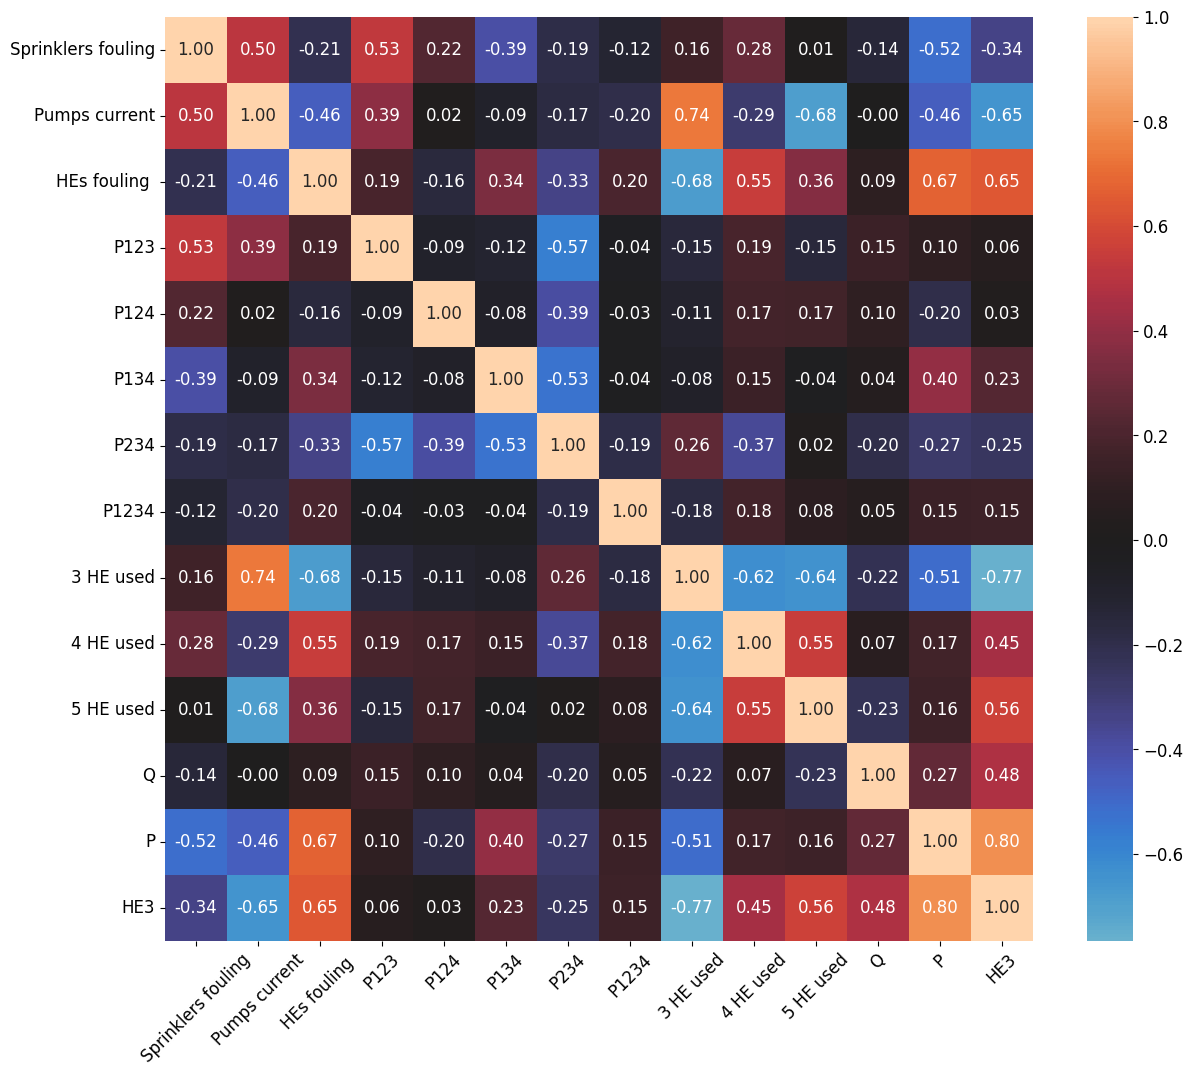

In [112]:
plt.figure(figsize=(14,12))
sns.heatmap(
    df_stats_Q2_heatmap.corr(method='spearman'), 
    annot=True, 
    fmt=".2f", 
    xticklabels=names, 
    yticklabels=names,
    center=0,
#     mask=mask
)
plt.xticks(rotation=45)

In [1450]:
from sklearn.multioutput import MultiOutputRegressor

In [1451]:
X = df_stats_Q2.drop(["Q2", "P2"], axis=1)
y = df_stats_Q2[["Q2", "P2"]]

In [1456]:
X.shape, y.shape

((5852, 3), (5852, 2))

In [1457]:
def evaluate(model, X, y, cv):
#     print(X)
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [1458]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [1360]:
pl = make_pipeline(
    ct,
#     HistGradientBoostingRegressor()
    GradientBoostingRegressor()
).set_output(transform="pandas")


In [1361]:
mor_pl = make_pipeline(
    ct,
#     HistGradientBoostingRegressor()
    MultiOutputRegressor(HistGradientBoostingRegressor())
).set_output(transform="pandas")

mor_pl_1 = make_pipeline(
    ct,
    MultiOutputRegressor(KNeighborsRegressor())
).set_output(transform="pandas")

mor_pl_2 = make_pipeline(
    ct,
    MultiOutputRegressor(tree.DecisionTreeRegressor())
).set_output(transform="pandas")

In [1362]:
# multioutput
mor_gbr = mor_pl.fit(X_train, y_train)
mor_pl_1.fit(X_train, y_train)
mor_pl_2.fit(X_train, y_train)

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_data',
                                                  StandardScaler(),
                                                  ['Nozzles_TOP',
                                                   'HE_TOP_mean']),
                                                 ('categorical_data',
                                                  OneHotEncoder(sparse=False),
                                                  ['pumps2'])])),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor()))])

1.1810663862490556
0.0005318917455837768


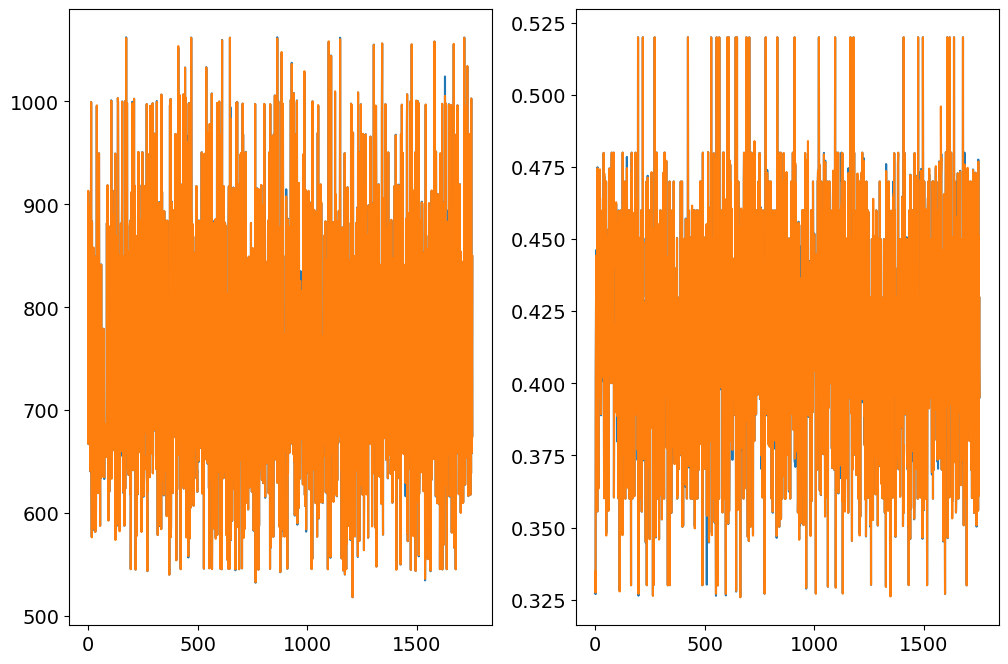

In [1363]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0]
)
sns.lineplot(
    mor_pl_1.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0]
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_pl_1.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_pl_1.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_pl_1.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

1.1366006025446933
0.00040289070283973296


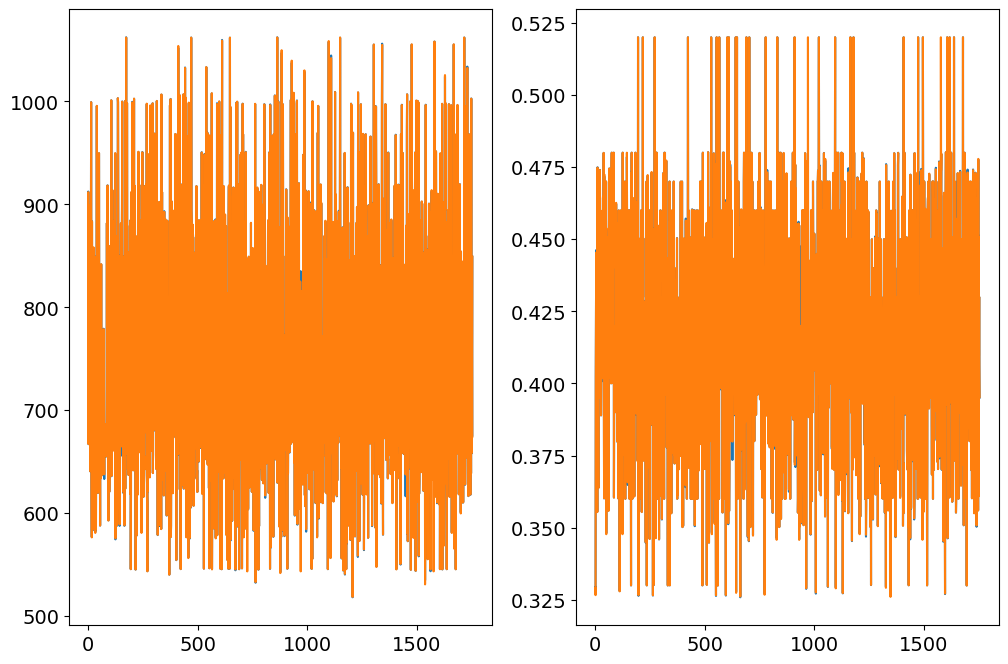

In [1364]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0]
)
sns.lineplot(
    mor_pl_2.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0]
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_pl_2.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_pl_2.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_pl_2.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

3.007548141627568
0.001207558397604518


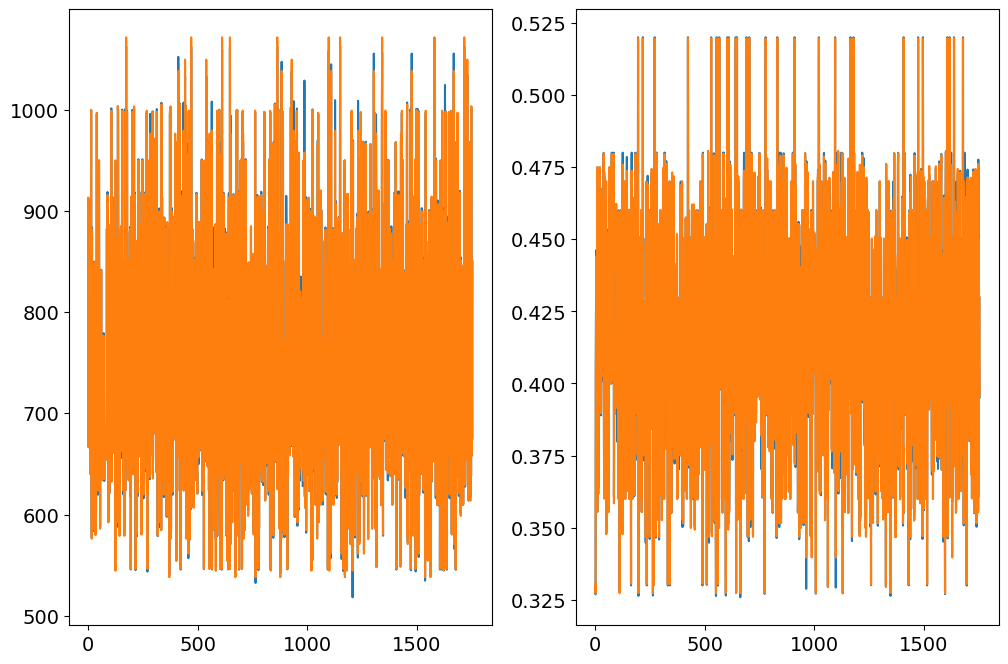

In [1365]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
# for n, (tr, te) in enumerate(folds):
# gbr.fit(
#     X_train,
#     y_train
# )

sns.lineplot(
    y_test["Q2"].to_numpy(),
    ax=axs[0],
)
sns.lineplot(
    mor_gbr.predict(
        X_test
    )[:, 0], # Q2
    ax=axs[0],
    errorbar=("pi", 100)
)

sns.lineplot(
    y_test["P2"].to_numpy(),
    ax=axs[1]
)
sns.lineplot(
    mor_gbr.predict(
        X_test
    )[:, 1], # Q2
    ax=axs[1]
)

print(mean_absolute_error(
    y_test["Q2"],
    mor_gbr.predict(
        X_test
    )[:, 0]
))
print(mean_absolute_error(
    y_test["P2"],
    mor_gbr.predict(
        X_test
    )[:, 1]
))
# gbr_pl1.steps[-1][1].feature_importances_*100, X.columns

## USE of folds to predict

In [1366]:
ss_folds = list(ShuffleSplit(n_splits=4).split(X,y))
k_folds = list(KFold(n_splits=4).split(X,y))

In [1367]:
gbr_pl1 = pl

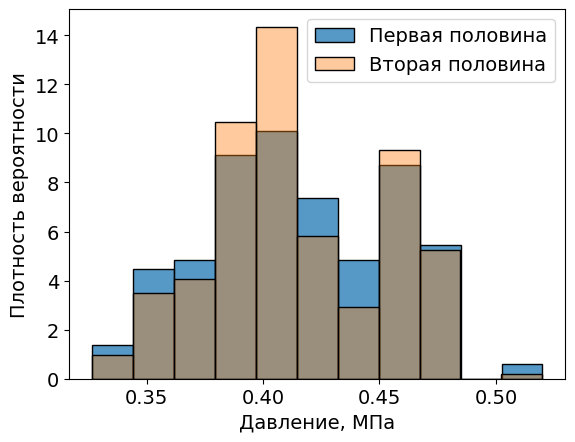

In [1368]:
sns.histplot(
    y.iloc[
        ss_folds[0][1][:int(len(ss_folds[0][1])/2)]
    ]["P2"],
    stat="density",
    label="Первая половина"
    
)

sns.histplot(
    y.iloc[
        ss_folds[0][1][int(len(ss_folds[0][1])/2): ]
    ]["P2"],
    stat="density",
    alpha=0.4,
    label="Вторая половина"
)
plt.xlabel("Давление, МПа")
plt.ylabel("Плотность вероятности")
plt.legend()

<AxesSubplot: xlabel='Q2', ylabel='Count'>

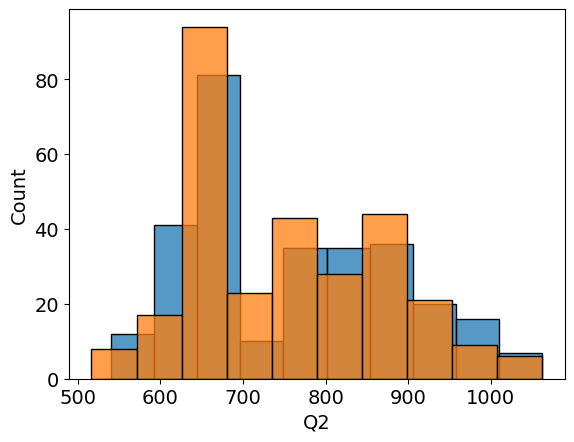

In [1369]:
sns.histplot(
    y.iloc[
        ss_folds[0][1][:int(len(ss_folds[0][1])/2)]
    ]["Q2"]
)

sns.histplot(
    y.iloc[
        ss_folds[0][1][int(len(ss_folds[0][1])/2): ]
    ]["Q2"]
)

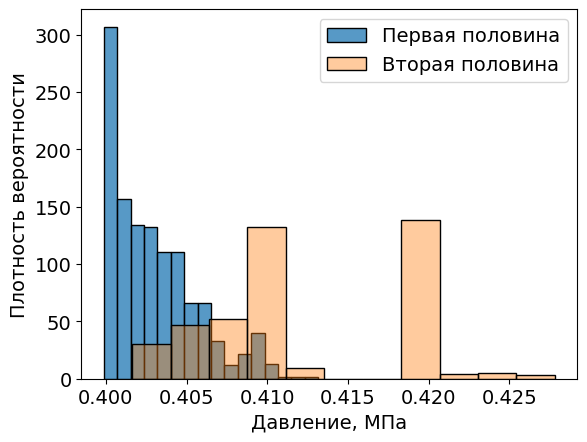

In [1370]:
sns.histplot(
    y.iloc[
        k_folds[0][1][:int(len(k_folds[0][1])/2)]
    ]["P2"],
    stat="density",
    label="Первая половина"
    
)

sns.histplot(
    y.iloc[
        k_folds[0][1][int(len(k_folds[0][1])/2): ]
    ]["P2"],
    stat="density",
    alpha=0.4,
    label="Вторая половина"
)
plt.xlabel("Давление, МПа")
plt.ylabel("Плотность вероятности")
plt.legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib

1.4575814552250652
245.80775130636363
single_pred 678.3723333333334 924.180084639697 432.56458202696973 678.26625
758.4244945576718 748.5868581387251 768.2621309766184
0.9270865093964827
29.341128435251527
single_pred 782.9400000000002 812.2811284352517 753.5988715647486 782.655
744.0123107535202 734.7676367306309 753.2569847764095
0.7893275736007807
15.627373052244467
single_pred 682.3261350579523 697.9535081101968 666.6987620057079 682.300551724619
744.4658373575494 734.7736760116702 754.1579987034286
0.8476785221022682
19.751185193244304
single_pred 850.5809999999999 870.3321851932442 830.8298148067556 850.2066666666667
751.7636938563653 741.9346559512139 761.5927317615167


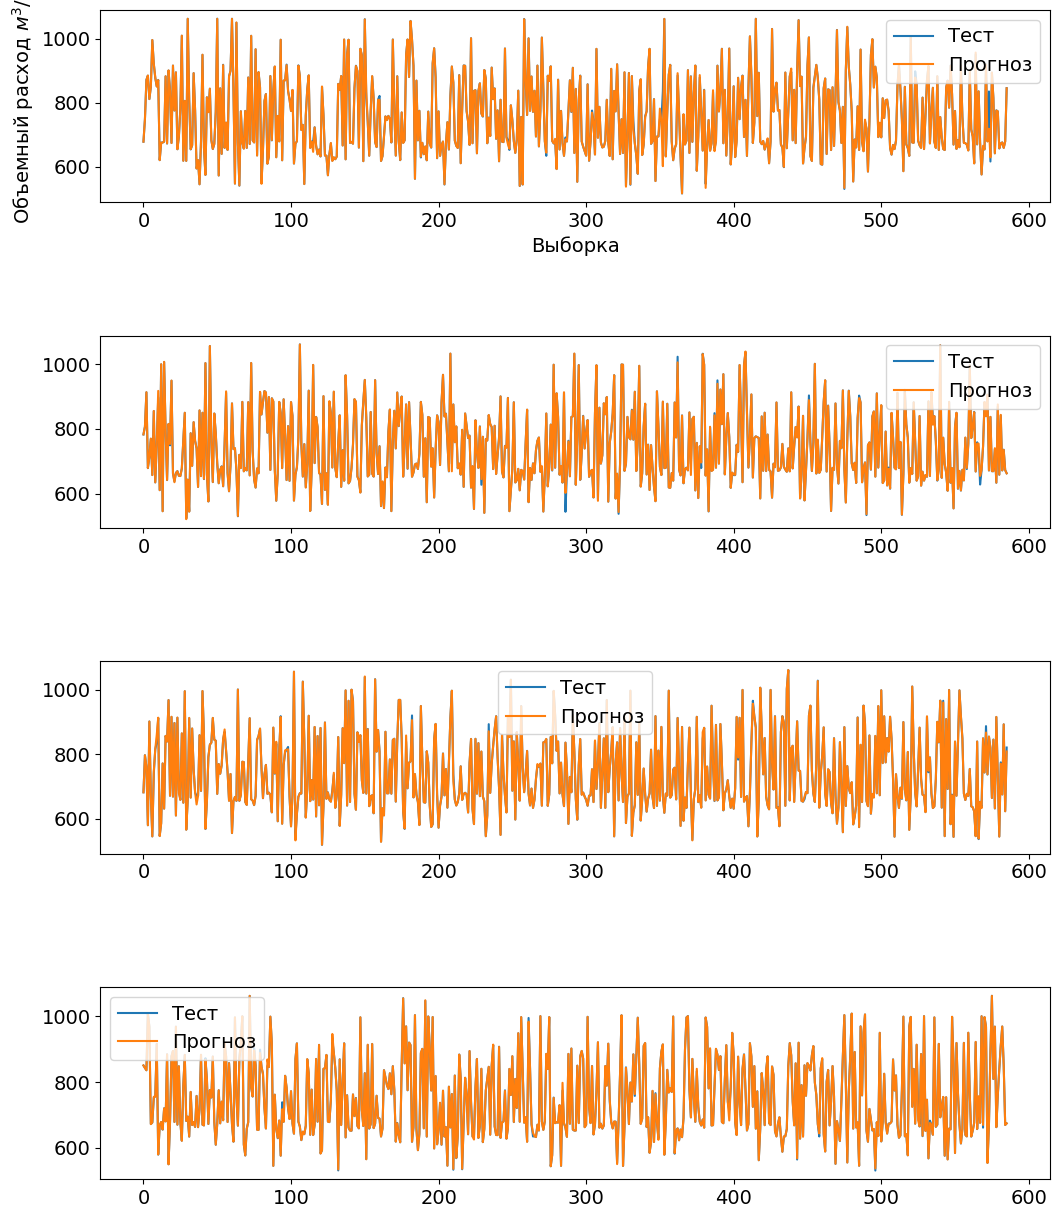

In [1371]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,14))
fig.tight_layout(pad=5.0)

level = 1.96
# pred_intr_upper

for n, (tr, te) in enumerate(ss_folds):
    mor_pl_1.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n],
        label="Тест"
    )
    
    pred = mor_pl_1.predict(
         X.iloc[te])[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n],
        label="Прогноз",
        errorbar="ci"
    )
    
    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    print(interval)
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper, y.iloc[te].iloc[0]["Q2"]
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1.5102431896039548
single_pred 677.9912499999999 1086.641270357922 269.3412296420779
759.0605862292267 749.2604883962185 768.8606840622349
1.105817519538577
single_pred 781.835 957.2532873314242 606.4167126685759
743.6829989173234 734.4128137688965 752.9531840657503
0.5720729907623558
single_pred 682.3534683912857 692.3047815571813 672.4021552253901
744.4572850829952 734.7833911601857 754.1311790058047


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.729025786567828
single_pred 850.6158333333333 881.4048392488858 819.8268274177808
751.5571229098556 741.7230967311081 761.3911490886031


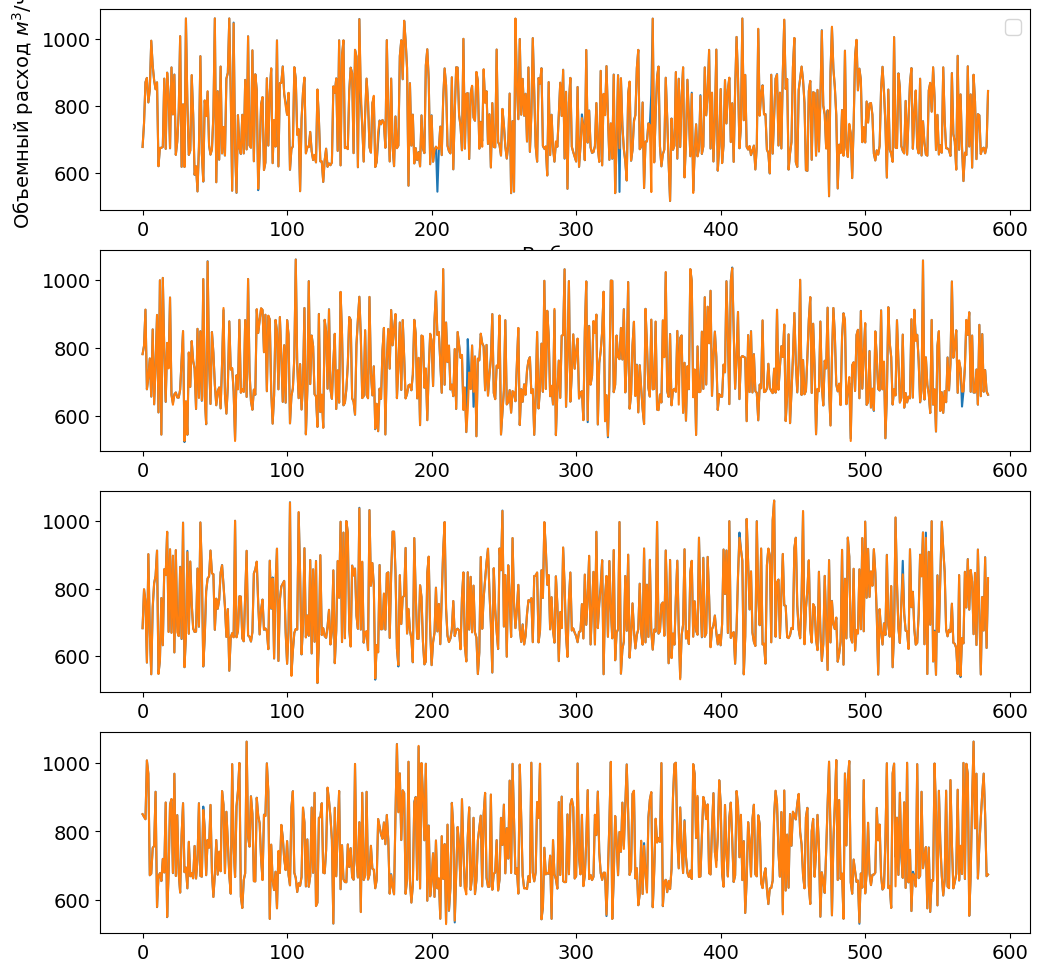

In [1372]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(ss_folds):
    mor_pl_2.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    
    pred = mor_pl_2.predict(
            X.iloc[te]
        )[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n]
    )

    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()

/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


3.2348741682761313
single_pred 678.7314425336587 870.0826206318532 487.38026443546414
758.2286515301722 748.4330447113919 768.0242583489526


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.944041190872883
single_pred 780.596291637823 1031.9388202117404 529.2537630639056
744.4011795986743 735.1982858560073 753.6040733413413


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2.535935337009526
single_pred 682.1703038642248 731.5906430387108 632.7499646897388
744.101692358077 734.476789219132 753.726595497022


/home/mrzlka/.pyenv/versions/3.10.0/envs/irt_cs_3.10.0/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.8168900969182085
single_pred 849.4781152800798 925.812747982012 773.1434825781477
751.3203272589859 741.5289250916642 761.1117294263076


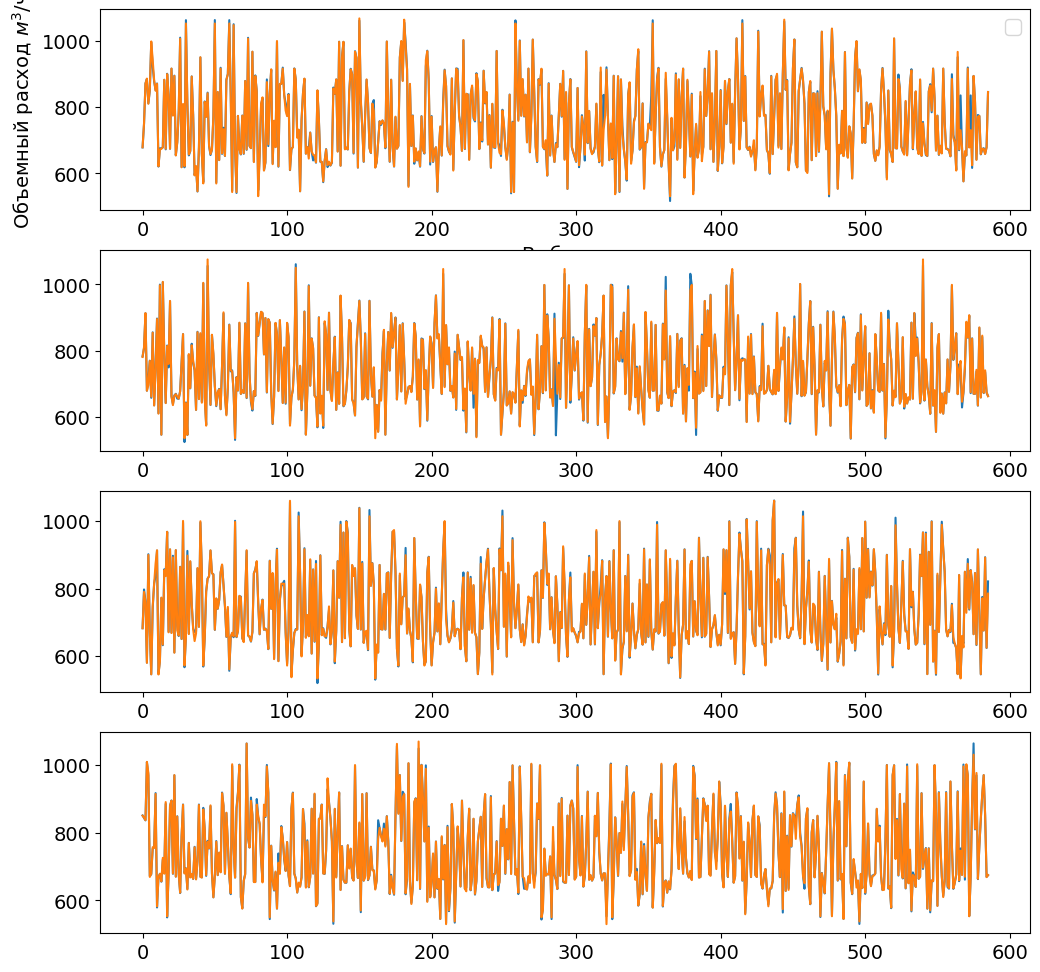

In [1373]:
fig, axs = plt.subplots(len(ss_folds),1, figsize=(12,12))

for n, (tr, te) in enumerate(ss_folds):
    mor_gbr.fit(
        X.iloc[tr],
        y.iloc[tr]
    )
    sns.lineplot(
        y.iloc[te]["Q2"].to_numpy(),
        ax=axs[n]
    )
    
    pred = mor_gbr.predict(
            X.iloc[te]
        )[:, 0]
    
    sns.lineplot(
        pred,
        ax=axs[n]
    )

    print(mean_absolute_error(
        y.iloc[te]["Q2"],
        pred
    ))
    
    interval = 1/( len(y.iloc[te]["Q2"]) - 2)\
        * sum(
            ( y.iloc[te]["Q2"].to_numpy() - pred ) ** 2
        ) * level
    
    lower, upper = pred[0] + interval, pred[0] - interval
    print(
        "single_pred", pred[0], lower, upper
    )
    
    ci_lower = np.mean(pred) - level * np.std( pred ) / np.sqrt( len(pred) )
    ci_upper = np.mean(pred) + level * np.std( pred ) / np.sqrt( len(pred) )
    
    print( np.mean(pred), ci_lower, ci_upper )
    
axs[0].set_xlabel("Выборка")
axs[0].set_ylabel("Объемный расход $м^3$/ч")
axs[0].legend()